In [1]:
import pandas as pd
import numpy as np
#import networkx as nx
#import matplotlib.pyplot as plt
#import time
#from scipy import stats
#import re

In [2]:
import torch
import math
import random
#import matplotlib.pyplot as plt
import torch.nn.functional as F

!pip install torch_geometric
#from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from ast import literal_eval

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

## Check the GPU and RAM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 24 17:22:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# method 1
#device = 0

In [4]:
# method 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GCN().to(device)
# data = dataset[0].to(device)

# *Read data

In [ ]:
# def str_to_int(l):
#     for i in range(len(l)):
#         l[i] = int(l[i])
#     return l

In [5]:
# # Jiaying path
edge_index = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/edge_index.pt') # Jiaying path
feature_emb32 = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/feature_emb32.pt') # Jiaying path

prev_items_train = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/prev_items_train.pt')
next_items_train = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/next_items_train.pt')

prev_items_test = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/prev_items_test.pt')
next_items_test = torch.load('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/next_items_test.pt')

trained_items = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/trained_items.csv')

# Jupyter
# edge_index = torch.load('/Users/jiayingliang/Desktop/sna_fp/edge_index.pt')
# feature_emb32 = torch.load('/Users/jiayingliang/Desktop/sna_fp/feature_emb32.pt')

# prev_items_train = torch.load('/Users/jiayingliang/Desktop/sna_fp/prev_items_train.pt')
# next_items_train = torch.load('/Users/jiayingliang/Desktop/sna_fp/next_items_train.pt')

# prev_items_test = torch.load('/Users/jiayingliang/Desktop/sna_fp/prev_items_test.pt')
# next_items_test = torch.load('/Users/jiayingliang/Desktop/sna_fp/next_items_test.pt')

# trained_items = pd.read_csv('/Users/jiayingliang/Desktop/sna_fp/trained_items.csv')

In [59]:
prev_items_train = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/trimmed_sessions_transformed.csv')
prev_items_test = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/sessions_test_transformed_trimmed.csv')

In [ ]:
# # Sovann path
# edge_index = torch.load('edge_index.pt')
# feature_emb32 = torch.load('feature_emb32.pt')

# prev_items_train = torch.load('prev_items_train.pt')
# next_items_train = torch.load('next_items_train.pt')

# prev_items_test = torch.load('prev_items_test.pt')
# next_items_test = torch.load('next_items_test.pt')

# trained_items = pd.read_csv('trained_items.csv')

## Preview

In [75]:
trained_items

,item
0,2
1,10
2,14
3,19
4,21
...,...
15381,118515
15382,118538
15383,118543
15384,118579


In [60]:
prev_items_train

,prev_items,next_item
0,"[0, 0, 18751, 19567, 90539]",41603
1,"[0, 0, 0, 0, 15083]",29242
2,"[0, 0, 37933, 37933, 7757]",7786
3,"[52037, 52224, 21130, 52283, 103463]",52223
4,"[0, 32533, 26082, 25742, 12554]",90699
...,...,...
19995,"[0, 0, 0, 0, 91694]",89461
19996,"[72924, 80731, 72924, 80731, 60623]",23458
19997,"[78156, 78164, 59975, 56823, 15240]",16940
19998,"[0, 0, 24747, 24748, 24747]",24750


In [62]:
from ast import literal_eval

prev_items_train["prev_items"] = prev_items_train["prev_items"].apply(literal_eval)
prev_items_train

,prev_items,next_item
0,"[0, 0, 18751, 19567, 90539]",41603
1,"[0, 0, 0, 0, 15083]",29242
2,"[0, 0, 37933, 37933, 7757]",7786
3,"[52037, 52224, 21130, 52283, 103463]",52223
4,"[0, 32533, 26082, 25742, 12554]",90699
...,...,...
19995,"[0, 0, 0, 0, 91694]",89461
19996,"[72924, 80731, 72924, 80731, 60623]",23458
19997,"[78156, 78164, 59975, 56823, 15240]",16940
19998,"[0, 0, 24747, 24748, 24747]",24750


In [61]:
prev_items_test

,prev_items,next_item,trained_on
0,"[0, 9351, 11520, 9351, 12548]",8334,True
1,"[0, 36641, 56265, 56270, 56514]",62787,True
2,"[0, 62828, 63327, 62828, 63327]",115432,True
3,"[0, 0, 0, 0, 75835]",7806,True
4,"[0, 36694, 118291, 118291, 36694]",35606,True
...,...,...,...
4995,"[0, 58817, 48410, 48410, 58817]",9482,True
4996,"[0, 0, 0, 0, 117704]",32855,True
4997,"[0, 0, 0, 117142, 80927]",96770,True
4998,"[0, 107790, 107799, 107790, 111573]",88645,True


In [63]:
from ast import literal_eval

prev_items_test["prev_items"] = prev_items_test["prev_items"].apply(literal_eval)
prev_items_test

,prev_items,next_item,trained_on
0,"[0, 9351, 11520, 9351, 12548]",8334,True
1,"[0, 36641, 56265, 56270, 56514]",62787,True
2,"[0, 62828, 63327, 62828, 63327]",115432,True
3,"[0, 0, 0, 0, 75835]",7806,True
4,"[0, 36694, 118291, 118291, 36694]",35606,True
...,...,...,...
4995,"[0, 58817, 48410, 48410, 58817]",9482,True
4996,"[0, 0, 0, 0, 117704]",32855,True
4997,"[0, 0, 0, 117142, 80927]",96770,True
4998,"[0, 107790, 107799, 107790, 111573]",88645,True


## Convert to tensor

In [64]:
prev_items_tensor_train = [torch.tensor(l) for l in prev_items_train.prev_items]
prev_items_tensor_train = torch.stack(prev_items_tensor_train)
prev_items_tensor_train

tensor([[    0,     0, 18751, 19567, 90539],
        [    0,     0,     0,     0, 15083],
        [    0,     0, 37933, 37933,  7757],
        ...,
        [78156, 78164, 59975, 56823, 15240],
        [    0,     0, 24747, 24748, 24747],
        [    0,     0,     0, 35376, 35929]])

In [66]:
prev_items_tensor_train.shape

torch.Size([20000, 5])

In [65]:
prev_items_tensor_test = [torch.tensor(l) for l in prev_items_test.prev_items]
prev_items_tensor_test = torch.stack(prev_items_tensor_test)
prev_items_tensor_test

tensor([[     0,   9351,  11520,   9351,  12548],
        [     0,  36641,  56265,  56270,  56514],
        [     0,  62828,  63327,  62828,  63327],
        ...,
        [     0,      0,      0, 117142,  80927],
        [     0, 107790, 107799, 107790, 111573],
        [     0,      0,      0,      0, 106257]])

In [67]:
prev_items_tensor_test.shape

torch.Size([5000, 5])

## *Trim feature_emb32 down to trained_items

In [17]:
trained_items.item

0             2
1            10
2            14
3            19
4            21
          ...  
15381    118515
15382    118538
15383    118543
15384    118579
15385    118592
Name: item, Length: 15386, dtype: int64

In [6]:
trimmed_feature_emb32 = feature_emb32[trained_items.item]

In [7]:
trimmed_feature_emb32.shape

torch.Size([15386, 32])

## *Trim edge_index down to trained_items

In [7]:
valid_prev = [i for i in range(len(edge_index[0])) if int(edge_index[0][i]) in trained_items.item]

In [9]:
len(valid_prev)

45112

In [8]:
valid_next = [i for i in valid_prev if int(edge_index[1][i]) in trained_items.item]

In [11]:
len(valid_next)

24077

In [12]:
edge_index

tensor([[     1,      3,      4,  ..., 118596, 118596, 118597],
        [  1294,      3,  66465,  ...,  76724,  77905, 118595]])

In [9]:
edge_index_t = edge_index.t()
edge_index_t

tensor([[     1,   1294],
        [     3,      3],
        [     4,  66465],
        ...,
        [118596,  76724],
        [118596,  77905],
        [118597, 118595]])

In [10]:
trimmed_edge_index = edge_index_t[valid_next].t()

In [11]:
trimmed_edge_index

tensor([[    1,     3,     6,  ..., 15385, 15385, 15385],
        [ 1294,     3,     6,  ..., 15362, 15383, 15384]])

In [12]:
trimmed_edge_index.shape

torch.Size([2, 24077])

# Modeling

## **The Model

In [13]:
# class GNNPredictor(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
#         super(GNNPredictor, self).__init__()

#         self.conv_layers = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])
#         for _ in range(num_layers - 1):
#             self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))

#         self.fc = torch.nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         # Apply graph convolution layers
#         for conv in self.conv_layers:
#             x = F.relu(conv(x, edge_index))

#         # Apply fully connected layer
#         x = self.fc(x)

#         return F.softmax(x, dim=1)

In [93]:
class GNNPredictor(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        input_dim = 32
        fc_input_dim = input_dim * 5

        # Want at least 2 layers
        if num_layers < 2:
            num_layers = 2

        super(GNNPredictor, self).__init__()
        self.conv_layers = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])

        if num_layers > 2:
            for _ in range(num_layers - 2):
                self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))

        self.conv_layers.append(GCNConv(hidden_dim, input_dim))

        self.fc = torch.nn.Linear(fc_input_dim, output_dim)

    def forward(self, prev_items, x, edge_index):
        # Apply graph convolution layers
        for conv in self.conv_layers:
            x = F.relu(conv(x, edge_index))

        # Get updated representation of previous items
        new_prev_items = []
        for prev_list in prev_items:
            new_prev_list = []

            for item in prev_list:
                new_prev_list.extend(x[item].tolist())

            new_prev_items.append(new_prev_list)

        # Apply fully connected layer
        new_prev_items = self.fc(torch.tensor(new_prev_items))
        return F.softmax(new_prev_items , dim=1)

Testing loss function

In [22]:
criterion(torch.log(torch.tensor([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])), torch.tensor([1, 2]))

tensor(1.1769)

In [26]:
prev_items_train.shape # 32 X 5 previous item encoding list, for 20000 sessions
#torch.Size([20000, 160])

next_items_train.shape # one hot encoded next item, for 20000 sessions
#torch.Size([20000, 15386])

indices.shape # index for next item, for 20000 sessions
#torch.Size([20000])

torch.Size([20000, 160])

In [30]:
next_item_train_onehot_list = next_items_train.tolist()
next_item_train_index = [i.index(1) for i in next_item_train_onehot_list]

In [31]:
next_items_train = torch.tensor(next_item_train_index)
next_items_train

tensor([5762, 4102, 1096,  ..., 2377, 3486, 2251])

In [45]:
next_item_test_onehot_list = next_items_test.tolist()
next_item_test_index = [i.index(1) for i in next_item_test_onehot_list]
next_items_test = torch.tensor(next_item_test_index)
next_items_test

tensor([ 1183,  8505, 15048,  ..., 12751, 11836,  9979])

In [160]:
# Instantiate the model
model = model = GNNPredictor(hidden_dim=64, output_dim=len(trained_items), num_layers=3)#.to(device)
trimmed_feature_emb32_gpu = trimmed_feature_emb32#.to(device)
trimmed_edge_index_gpu = trimmed_edge_index#.to(device)
criterion = torch.nn.NLLLoss() #BCEWithLogitsLoss() #CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [161]:
model.train()

GNNPredictor(
  (conv_layers): ModuleList(
    (0): GCNConv(32, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 32)
  )
  (fc): Linear(in_features=160, out_features=15386, bias=True)
)

In [162]:
prev_items_tensor_train

tensor([[    0,     0, 18751, 19567, 90539],
        [    0,     0,     0,     0, 15083],
        [    0,     0, 37933, 37933,  7757],
        ...,
        [78156, 78164, 59975, 56823, 15240],
        [    0,     0, 24747, 24748, 24747],
        [    0,     0,     0, 35376, 35929]])

In [163]:
num_samples = len(prev_items_train)

In [164]:
epochs = 500

In [166]:
for epoch in range(epochs):
    indices = torch.randperm(num_samples)

    optimizer.zero_grad()

    predictions = model(prev_items_tensor_train, feature_emb32.float(), trimmed_edge_index)

    loss = criterion(torch.log(predictions), next_items_train)

    loss.backward()

    optimizer.step()


    if epoch % 25 == 0:
        print(f"Epoch {epoch + 1}/{epochs} Loss: {loss.item()}")

Epoch 1/500 Loss: 9.71547794342041
Epoch 26/500 Loss: 9.50774097442627
Epoch 51/500 Loss: 9.47382926940918
Epoch 76/500 Loss: 9.44333267211914
Epoch 101/500 Loss: 9.412853240966797
Epoch 126/500 Loss: 9.382537841796875
Epoch 151/500 Loss: 9.352702140808105
Epoch 176/500 Loss: 9.323561668395996
Epoch 201/500 Loss: 9.295222282409668
Epoch 226/500 Loss: 9.267718315124512
Epoch 251/500 Loss: 9.24103832244873
Epoch 276/500 Loss: 9.2151460647583
Epoch 301/500 Loss: 9.189994812011719
Epoch 326/500 Loss: 9.165541648864746
Epoch 351/500 Loss: 9.14173412322998
Epoch 376/500 Loss: 9.118525505065918
Epoch 401/500 Loss: 9.09587574005127
Epoch 426/500 Loss: 9.07374382019043
Epoch 451/500 Loss: 9.052091598510742
Epoch 476/500 Loss: 9.030884742736816


In [106]:
 predictions.shape

torch.Size([20000, 15386])

In [107]:
torch.log(predictions)[0]

tensor([ -9.9056, -10.6574,  -9.7769,  ..., -10.0381,  -9.7160,  -8.2260],
       grad_fn=<SelectBackward0>)

In [108]:
next_items_train.shape

torch.Size([20000])

In [109]:
loss

tensor(9.9751, grad_fn=<NllLossBackward0>)

### Making predictions

In [167]:
model.eval()

GNNPredictor(
  (conv_layers): ModuleList(
    (0): GCNConv(32, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 32)
  )
  (fc): Linear(in_features=160, out_features=15386, bias=True)
)

In [168]:
with torch.no_grad():
    predictions = model(prev_items_tensor_test, feature_emb32.float(), trimmed_edge_index)

### Evaluation

In [169]:
placements = []

In [170]:
for i in range(len(next_items_test)):
    df = pd.DataFrame(predictions[i].tolist(), columns=["probs"])
    df = df.sort_values(by="probs", ascending=False).reset_index()
    placements.append(df[df["index"] == next_items_test.tolist()[i]].index[0])

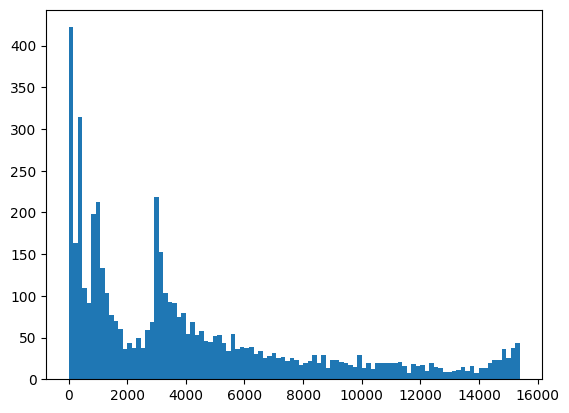

In [171]:
import matplotlib.pyplot as plt
plt.hist(placements, bins=100)
plt.show()

Number of products to choose from:

In [178]:
len(trained_items)

15386

Number of test sessions

In [179]:
len(placements)

5000

Number of predictions where the actual next product was the top predicted item

In [173]:
len([num for num in placements if num < 1])

8

Number of predictions where the actual next product was in the top 10, 25, 50, and 100 predicted items

In [174]:
len([num for num in placements if num < 10])

64

In [175]:
len([num for num in placements if num < 25])

124

In [176]:
len([num for num in placements if num < 50])

203

In [177]:
len([num for num in placements if num < 100])

315